## Data

In [231]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
#https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

In [232]:
df = pd.read_csv(r"data/2105 Data Science Campaign Optimization facebook_ad_hourly_v01.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54314 entries, 0 to 54313
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   54314 non-null  int64  
 1   campaign_id  54314 non-null  int64  
 2   ad_id        54314 non-null  int64  
 3   date         54314 non-null  object 
 4   time         54314 non-null  object 
 5   spend        54314 non-null  float64
 6   reach        0 non-null      float64
 7   impressions  54314 non-null  int64  
 8   clicks       54314 non-null  int64  
 9   purchase     388 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 4.1+ MB


Dropping unnecessary Unnamed: 0 column and replace nan values

In [233]:
# dropping unnecessary Unnamed: 0 column
df = df.drop(["Unnamed: 0", 'reach'],axis=1)
# Replace None in the purchase value to 0
df['purchase'] = df['purchase'].fillna(0)
df.head()

,campaign_id,ad_id,date,time,spend,impressions,clicks,purchase
0,23843490210650549,23843490222550549,2019-07-18,07:00:00 - 07:59:59,0.04,6,0,0.0
1,23843490210650549,23843490222600549,2019-07-18,07:00:00 - 07:59:59,0.00,2,0,0.0
2,23843490210650549,23843490222650549,2019-07-18,07:00:00 - 07:59:59,0.00,1,0,0.0
3,23843490210650549,23843490222880549,2019-07-18,07:00:00 - 07:59:59,0.04,5,0,0.0
4,23843490224560549,23843490225720549,2019-07-18,07:00:00 - 07:59:59,0.01,1,0,0.0


Convert date columns to appropuate format and add time to date

In [234]:
df['date'] = pd.to_datetime(df['date'])
df['hour'] = pd.to_datetime(df['time'].apply(lambda x: str(x).split('-')[0].strip()), format='%H:%M:%S').dt.hour
df['datetime'] = df['date']
df['datetime']+=  pd.to_timedelta(df.hour, unit='h')

# df['month'] = df['date'].dt.dayofweek # 0 is monday
# df['year'] = df['date'].dt.year
# df["quarter"] = df['month'] // 4 + 1
# #valid features with month column
# df['dayofweek'] = df['date'].dt.dayofweek
# df['dayofyear'] = df['date'].dt.dayofyear
# df['hour'] = pd.to_datetime(df['time'].apply(lambda x: str(x).split('-')[0].strip()), format='%H:%M:%S').dt.hour

## Prepare and store valid series in data

Combine campaign and id to get unique series or ids

In [235]:
df['campaign_id'] = ['campaign_id_' + str(i) for i in df['campaign_id']]
df['ad_id'] = ['ad_id_' + str(i) for i in df['ad_id']]
df['unique_ids'] = df[['campaign_id', 'ad_id']].apply(lambda x: '_'.join(x), axis=1)
df_raw = df.copy()
df.drop(['campaign_id', 'ad_id', 'date'], axis=1, inplace=True)
print('There are {} unique series found in the given data set.'.format(df_raw.unique_ids.nunique()))

There are 1061 unique series found in the given data set.


#### Identify first 24 hours and extract endtime for each advertisement
Check if each series has valid end date or not

In [236]:
unique_campaign_advertisement_info = df[['unique_ids','datetime']].sort_values(['datetime']).groupby('unique_ids').first().reset_index()
unique_campaign_advertisement_info['last_hour'] = unique_campaign_advertisement_info['datetime']+ timedelta(hours=23)
unique_campaign_advertisement_info = unique_campaign_advertisement_info.rename(columns={'datetime':'first_hour'})

# check timeline validity
unique_campaign_advertisement_info ['valid_timeline'] = unique_campaign_advertisement_info['last_hour']<df['datetime'].max()
unique_campaign_advertisement_info = unique_campaign_advertisement_info[unique_campaign_advertisement_info.valid_timeline>0]


#extract end time of each serues
unique_campaign_advertisement_info = unique_campaign_advertisement_info.set_index('unique_ids')
unique_campaign_advertisement_info['endtime'] = df.sort_values('datetime').groupby('unique_ids').last()[['datetime']]
unique_campaign_advertisement_info

,first_hour,last_hour,valid_timeline,endtime
unique_ids,,,,
campaign_id_23843427462090549_ad_id_23843429354180549,2019-06-21 12:00:00,2019-06-22 11:00:00,True,2019-06-23 23:00:00
campaign_id_23843427462090549_ad_id_23843429359190549,2019-06-21 12:00:00,2019-06-22 11:00:00,True,2019-06-23 23:00:00
campaign_id_23843427462090549_ad_id_23843429359200549,2019-06-21 13:00:00,2019-06-22 12:00:00,True,2019-06-23 12:00:00
campaign_id_23843429400540549_ad_id_23843429400560549,2019-06-21 12:00:00,2019-06-22 11:00:00,True,2019-06-23 12:00:00
campaign_id_23843429400540549_ad_id_23843429400570549,2019-06-21 12:00:00,2019-06-22 11:00:00,True,2019-06-23 22:00:00
...,...,...,...,...
campaign_id_23845347387450549_ad_id_23845347387470549,2020-08-28 16:00:00,2020-08-29 15:00:00,True,2020-09-04 00:00:00
campaign_id_23845373948350549_ad_id_23845373948370549,2020-08-31 13:00:00,2020-09-01 12:00:00,True,2020-09-06 12:00:00
campaign_id_23845467764400549_ad_id_23845467764450549,2020-09-09 02:00:00,2020-09-10 01:00:00,True,2020-09-14 00:00:00


In [237]:
# (unique_campaign_advertisement_info[['last_hour']]+\
#  pd.to_timedelta(1, unit='h'))['last_hour'].values

#### Extract campaign advertisements that lasts 24+n hours

In [238]:
n = 1
unique_campaign_advertisement_info['duration_hours']=(unique_campaign_advertisement_info['endtime']-unique_campaign_advertisement_info['first_hour']).astype('timedelta64[h]')
unique_campaign_advertisement_info = unique_campaign_advertisement_info[unique_campaign_advertisement_info.duration_hours>=(n+24)]
#unique_campaign_advertisement_info.loc[:,'test_set'] = unique_campaign_advertisement_info['last_hour']+ pd.to_timedelta(n, unit='h')
print(unique_campaign_advertisement_info.shape)
unique_campaign_advertisement_info

(870, 5)


,first_hour,last_hour,valid_timeline,endtime,duration_hours
unique_ids,,,,,
campaign_id_23843427462090549_ad_id_23843429354180549,2019-06-21 12:00:00,2019-06-22 11:00:00,True,2019-06-23 23:00:00,59.0
campaign_id_23843427462090549_ad_id_23843429359190549,2019-06-21 12:00:00,2019-06-22 11:00:00,True,2019-06-23 23:00:00,59.0
campaign_id_23843427462090549_ad_id_23843429359200549,2019-06-21 13:00:00,2019-06-22 12:00:00,True,2019-06-23 12:00:00,47.0
campaign_id_23843429400540549_ad_id_23843429400560549,2019-06-21 12:00:00,2019-06-22 11:00:00,True,2019-06-23 12:00:00,48.0
campaign_id_23843429400540549_ad_id_23843429400570549,2019-06-21 12:00:00,2019-06-22 11:00:00,True,2019-06-23 22:00:00,58.0
...,...,...,...,...,...
campaign_id_23845345434590549_ad_id_23845345434720549,2020-08-28 16:00:00,2020-08-29 15:00:00,True,2020-09-04 12:00:00,164.0
campaign_id_23845347387450549_ad_id_23845347387470549,2020-08-28 16:00:00,2020-08-29 15:00:00,True,2020-09-04 00:00:00,152.0
campaign_id_23845373948350549_ad_id_23845373948370549,2020-08-31 13:00:00,2020-09-01 12:00:00,True,2020-09-06 12:00:00,143.0


#### Histogram of duration of the advertisements

array([[<AxesSubplot:title={'center':'duration_hours'}>]], dtype=object)

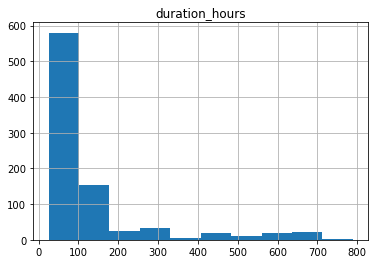

In [239]:
unique_campaign_advertisement_info[['duration_hours']].hist()

#### Put all valid series together in a dataframe

In [240]:
%%time

index = 1
prepared_df = None
test_days_per_ad= 3 #best 3 ~5.17638036809816%

grouped_unique_ids = df.sort_values(['datetime']).groupby('unique_ids')

for group_name,series in grouped_unique_ids:

    #=='campaign_id_23843427462090549_ad_id_23843429354180549':
    if group_name in unique_campaign_advertisement_info.index.values:
        print('{}. Valid Ids {}: duration in hours {}'.format(index, group_name, series.shape[0]))  
        
        last_hour = unique_campaign_advertisement_info[unique_campaign_advertisement_info.index == group_name]\
                    .last_hour.values[0]
        test_set_end = last_hour+pd.to_timedelta(test_days_per_ad, unit='h')

        series=series.set_index('datetime') 
        series = series.resample('H').asfreq()
        series['unique_ids'] = group_name
        series = series.fillna(0).reset_index()
        
        # extracts next hour clicks and purchase
#         series = series.assign(next_hour_clicks=series.clicks.shift(-1))
#         series = series.assign(next_hour_purchases=series.purchase.shift(-1))
        
        ###Chooses only valid ad up to n hours
        #series = series[series['datetime']<=(last_hour+pd.to_timedelta(n, unit='h'))]
        
        series['first_24_hour'] = series['datetime']<=last_hour
        series['test_set'] =(series['datetime']>last_hour) & (series['datetime']<=test_set_end)
        prepared_df = series if index==1 else prepared_df.append(series)
        index+=1

1. Valid Ids campaign_id_23843427462090549_ad_id_23843429354180549: duration in hours 59
2. Valid Ids campaign_id_23843427462090549_ad_id_23843429359190549: duration in hours 60
3. Valid Ids campaign_id_23843427462090549_ad_id_23843429359200549: duration in hours 23
4. Valid Ids campaign_id_23843429400540549_ad_id_23843429400560549: duration in hours 11
5. Valid Ids campaign_id_23843429400540549_ad_id_23843429400570549: duration in hours 59
6. Valid Ids campaign_id_23843429400540549_ad_id_23843429400590549: duration in hours 40
7. Valid Ids campaign_id_23843437921360549_ad_id_23843437921420549: duration in hours 252
8. Valid Ids campaign_id_23843437921380549_ad_id_23843437921400549: duration in hours 236
9. Valid Ids campaign_id_23843437921380549_ad_id_23843437921450549: duration in hours 226
10. Valid Ids campaign_id_23843490210650549_ad_id_23843490212110549: duration in hours 32
11. Valid Ids campaign_id_23843490210650549_ad_id_23843490212120549: duration in hours 312
12. Valid Ids c

105. Valid Ids campaign_id_23843490210650549_ad_id_23843504283260549: duration in hours 449
106. Valid Ids campaign_id_23843490210650549_ad_id_23843504283270549: duration in hours 120
107. Valid Ids campaign_id_23843490210650549_ad_id_23843504283280549: duration in hours 450
108. Valid Ids campaign_id_23843490210650549_ad_id_23843504283290549: duration in hours 452
109. Valid Ids campaign_id_23843490210650549_ad_id_23843504283300549: duration in hours 112
110. Valid Ids campaign_id_23843490210650549_ad_id_23843504283310549: duration in hours 122
111. Valid Ids campaign_id_23843490210650549_ad_id_23843504283320549: duration in hours 92
112. Valid Ids campaign_id_23843490210650549_ad_id_23843504283330549: duration in hours 119
113. Valid Ids campaign_id_23843490210650549_ad_id_23843504283340549: duration in hours 115
114. Valid Ids campaign_id_23843490210650549_ad_id_23843504283350549: duration in hours 111
115. Valid Ids campaign_id_23843490210650549_ad_id_23843504283360549: duration in

203. Valid Ids campaign_id_23843490224560549_ad_id_23843490237710549: duration in hours 58
204. Valid Ids campaign_id_23843490224560549_ad_id_23843490237720549: duration in hours 54
205. Valid Ids campaign_id_23843490224560549_ad_id_23843490237730549: duration in hours 53
206. Valid Ids campaign_id_23843490224560549_ad_id_23843490237850549: duration in hours 273
207. Valid Ids campaign_id_23843490224560549_ad_id_23843490238510549: duration in hours 203
208. Valid Ids campaign_id_23843490224560549_ad_id_23843504291900549: duration in hours 64
209. Valid Ids campaign_id_23843490224560549_ad_id_23843504291930549: duration in hours 74
210. Valid Ids campaign_id_23843490224560549_ad_id_23843504291970549: duration in hours 81
211. Valid Ids campaign_id_23843490224560549_ad_id_23843504292000549: duration in hours 80
212. Valid Ids campaign_id_23843490224560549_ad_id_23843504292020549: duration in hours 76
213. Valid Ids campaign_id_23843490224560549_ad_id_23843504292030549: duration in hours 

297. Valid Ids campaign_id_23843769769110549_ad_id_23843769804930549: duration in hours 41
298. Valid Ids campaign_id_23843769769110549_ad_id_23843769804980549: duration in hours 170
299. Valid Ids campaign_id_23843769769110549_ad_id_23843769805180549: duration in hours 7
300. Valid Ids campaign_id_23843769769110549_ad_id_23843769805190549: duration in hours 250
301. Valid Ids campaign_id_23843769769110549_ad_id_23843769806460549: duration in hours 35
302. Valid Ids campaign_id_23843769769110549_ad_id_23843769806490549: duration in hours 38
303. Valid Ids campaign_id_23843769769110549_ad_id_23843769806500549: duration in hours 14
304. Valid Ids campaign_id_23843769769110549_ad_id_23843769806510549: duration in hours 170
305. Valid Ids campaign_id_23843769769110549_ad_id_23843769806870549: duration in hours 20
306. Valid Ids campaign_id_23843769769110549_ad_id_23843769807980549: duration in hours 58
307. Valid Ids campaign_id_23843769769110549_ad_id_23843769807990549: duration in hours 

400. Valid Ids campaign_id_23843769822320549_ad_id_23843769837290549: duration in hours 2
401. Valid Ids campaign_id_23843769822320549_ad_id_23843769837300549: duration in hours 12
402. Valid Ids campaign_id_23843769822320549_ad_id_23843769837420549: duration in hours 13
403. Valid Ids campaign_id_23843769822320549_ad_id_23843769837860549: duration in hours 93
404. Valid Ids campaign_id_23843769822320549_ad_id_23843769837920549: duration in hours 54
405. Valid Ids campaign_id_23843769822320549_ad_id_23843769838030549: duration in hours 47
406. Valid Ids campaign_id_23843769822320549_ad_id_23843769838050549: duration in hours 36
407. Valid Ids campaign_id_23843769822320549_ad_id_23843769838220549: duration in hours 48
408. Valid Ids campaign_id_23843769822320549_ad_id_23843769838950549: duration in hours 43
409. Valid Ids campaign_id_23843769822320549_ad_id_23843769839030549: duration in hours 32
410. Valid Ids campaign_id_23843769822320549_ad_id_23843769839040549: duration in hours 34


498. Valid Ids campaign_id_23844530190320549_ad_id_23844530201710549: duration in hours 43
499. Valid Ids campaign_id_23844530190320549_ad_id_23844530202080549: duration in hours 34
500. Valid Ids campaign_id_23844530190320549_ad_id_23844530202620549: duration in hours 49
501. Valid Ids campaign_id_23844530190320549_ad_id_23844530202910549: duration in hours 33
502. Valid Ids campaign_id_23844530190320549_ad_id_23844530203350549: duration in hours 77
503. Valid Ids campaign_id_23844530190320549_ad_id_23844530203810549: duration in hours 18
504. Valid Ids campaign_id_23844530190320549_ad_id_23844530204140549: duration in hours 76
505. Valid Ids campaign_id_23844530190320549_ad_id_23844530204690549: duration in hours 24
506. Valid Ids campaign_id_23844530190320549_ad_id_23844530205470549: duration in hours 75
507. Valid Ids campaign_id_23844530190320549_ad_id_23844530205980549: duration in hours 23
508. Valid Ids campaign_id_23844530190320549_ad_id_23844530206310549: duration in hours 39

604. Valid Ids campaign_id_23844530190320549_ad_id_23844535406730549: duration in hours 35
605. Valid Ids campaign_id_23844530214060549_ad_id_23844530234520549: duration in hours 12
606. Valid Ids campaign_id_23844530214060549_ad_id_23844530236210549: duration in hours 24
607. Valid Ids campaign_id_23844530214060549_ad_id_23844530238760549: duration in hours 33
608. Valid Ids campaign_id_23844530214060549_ad_id_23844530242480549: duration in hours 33
609. Valid Ids campaign_id_23844530214060549_ad_id_23844530246000549: duration in hours 29
610. Valid Ids campaign_id_23844530214060549_ad_id_23844530247800549: duration in hours 19
611. Valid Ids campaign_id_23844530214060549_ad_id_23844530250170549: duration in hours 19
612. Valid Ids campaign_id_23844530214060549_ad_id_23844530253870549: duration in hours 28
613. Valid Ids campaign_id_23844530214060549_ad_id_23844530258990549: duration in hours 30
614. Valid Ids campaign_id_23844530214060549_ad_id_23844530262090549: duration in hours 72

700. Valid Ids campaign_id_23844530214060549_ad_id_23844531745400549: duration in hours 28
701. Valid Ids campaign_id_23844530214060549_ad_id_23844531746190549: duration in hours 40
702. Valid Ids campaign_id_23844530214060549_ad_id_23844535454630549: duration in hours 38
703. Valid Ids campaign_id_23844530214060549_ad_id_23844535454650549: duration in hours 9
704. Valid Ids campaign_id_23844530214060549_ad_id_23844535454670549: duration in hours 4
705. Valid Ids campaign_id_23844530214060549_ad_id_23844535454680549: duration in hours 12
706. Valid Ids campaign_id_23844530214060549_ad_id_23844535454690549: duration in hours 44
707. Valid Ids campaign_id_23844530214060549_ad_id_23844535454700549: duration in hours 29
708. Valid Ids campaign_id_23844530214060549_ad_id_23844535454710549: duration in hours 22
709. Valid Ids campaign_id_23844530214060549_ad_id_23844535454730549: duration in hours 23
710. Valid Ids campaign_id_23844530214060549_ad_id_23844535454750549: duration in hours 7
71

795. Valid Ids campaign_id_23844530214060549_ad_id_23844535490680549: duration in hours 108
796. Valid Ids campaign_id_23844530214060549_ad_id_23844535490700549: duration in hours 24
797. Valid Ids campaign_id_23844530214060549_ad_id_23844535490730549: duration in hours 36
798. Valid Ids campaign_id_23844530214060549_ad_id_23844535490740549: duration in hours 15
799. Valid Ids campaign_id_23844530214060549_ad_id_23844535490760549: duration in hours 19
800. Valid Ids campaign_id_23844530214060549_ad_id_23844535490770549: duration in hours 33
801. Valid Ids campaign_id_23844530214060549_ad_id_23844535490790549: duration in hours 28
802. Valid Ids campaign_id_23844530214060549_ad_id_23844535490800549: duration in hours 31
803. Valid Ids campaign_id_23845069571510549_ad_id_23845069572730549: duration in hours 74
804. Valid Ids campaign_id_23845069571510549_ad_id_23845069573040549: duration in hours 43
805. Valid Ids campaign_id_23845069571510549_ad_id_23845069573800549: duration in hours 4

In [225]:
#prepared_df[prepared_df['unique_ids']=='campaign_id_23843427462090549_ad_id_23843429354180549']

In [226]:
prepared_df.to_csv(r"data/prepared_data.csv".format(n), index=False)

## Defining and calculate Target Metric 
    The target metric consists of two KPI
    - Click Through Rate: clicks/impressions
    - Conversion Rate: purchase/clicks
   **A custom weighted conversion rate:** $(avgCTR+2*avgConversionRate)/3$
   
   <span style="font-family:Comic Sans MS">
    <a href="https://www.wordstream.com/click-through-rate">Average CTR: 0.35%</a>
    <br>
    <a href="https://www.wordstream.com/blog/ws/2014/03/17/what-is-a-good-conversion-rate#:~:text=going%20to%20go%3F-,But%20what%20is%20a%20good%20conversion%20rate%3F,rates%20of%2011.45%25%20or%20higher.">Average Conversion rate: 2.35%</a>
   </span>

Ads beyond the threshold of the custom weighted conversion rate: 1.683 will be considered as good ads.

In [207]:
avg_custom_conversion_rate = 1.683

#calculate ctr and checks for non-sensical value (i.e. >100%)
prepared_df['ctr'] = prepared_df.clicks/prepared_df.impressions*100
prepared_df.loc[prepared_df['ctr'] ==np.inf, 'ctr'] = 100
prepared_df.loc[prepared_df['ctr']>100, 'ctr'] = 100
prepared_df['ctr'] = prepared_df['ctr'].fillna(0)

#calculate conversion rate  and checks for non-sensical value (i.e. >100%)
prepared_df['conversion_rate'] = prepared_df.purchase/prepared_df.clicks*100
prepared_df.loc[prepared_df['conversion_rate'] ==np.inf, 'conversion_rate'] = 100
prepared_df.loc[prepared_df['conversion_rate']>100, 'conversion_rate'] = 100
prepared_df['conversion_rate'] = prepared_df['conversion_rate'].fillna(0)

#calculate custom conversion rate
prepared_df['custom_conversion_rate'] = (prepared_df['ctr']+(prepared_df['conversion_rate']*2))/3
prepared_df['good_performance'] = prepared_df['custom_conversion_rate']>=avg_custom_conversion_rate

#extract hour
prepared_df['hour'] = prepared_df['datetime'].dt.hour
prepared_df['dayofweek'] = prepared_df['datetime'].dt.dayofweek

#extract boolean clicked and purchase value
prepared_df['clicked'] = prepared_df['clicks']>0
prepared_df['purchased'] = prepared_df['purchase']>0

#Creates next hour customer conversion rate column
prepared_df = prepared_df.assign(next_hour_custom_conversion_rate = prepared_df.groupby(['unique_ids']).custom_conversion_rate.shift(-1))
prepared_df = prepared_df.assign(next_hour_good_performance = prepared_df.groupby(['unique_ids']).good_performance.shift(-1))

# # extracts next hour clicks and purchase
prepared_df = prepared_df.assign(next_hour_clicks = prepared_df.groupby(['unique_ids']).clicks.shift(-1))
prepared_df = prepared_df.assign(next_hour_purchases = prepared_df.groupby(['unique_ids']).purchase.shift(-1))
prepared_df.shape[0],len(prepared_df['unique_ids'].unique()),  prepared_df.shape[0]/len(prepared_df['unique_ids'].unique())

#campaign_id_23843427462090549_ad_id_23843429354180549
#prepared_df = prepared_df[prepared_df['prediction_horizon'] | prepared_df['first_24_hour']]

#prepared_df  = prepared_df.dropna()
##prepared_df

(113687, 870, 130.67471264367816)

## EDA

In [211]:
prepared_df[prepared_df.unique_ids=='campaign_id_23843427462090549_ad_id_23843429354180549']

,datetime,time,spend,impressions,clicks,purchase,hour,unique_ids,first_24_hour,test_set,...,conversion_rate,custom_conversion_rate,good_performance,dayofweek,clicked,purchased,next_hour_custom_conversion_rate,next_hour_good_performance,next_hour_clicks,next_hour_purchases
0,2019-06-21 12:00:00,12:00:00 - 12:59:59,0.00,1.0,0.0,0.0,12,campaign_id_23843427462090549_ad_id_2384342935...,True,False,...,0.0,0.000000,False,4,False,False,0.000000,False,0.0,0.0
1,2019-06-21 13:00:00,13:00:00 - 13:59:59,0.00,2.0,0.0,0.0,13,campaign_id_23843427462090549_ad_id_2384342935...,True,False,...,0.0,0.000000,False,4,False,False,0.000000,False,0.0,0.0
2,2019-06-21 14:00:00,0,0.00,0.0,0.0,0.0,14,campaign_id_23843427462090549_ad_id_2384342935...,True,False,...,0.0,0.000000,False,4,False,False,1.179941,False,4.0,0.0
3,2019-06-21 15:00:00,15:00:00 - 15:59:59,1.26,113.0,4.0,0.0,15,campaign_id_23843427462090549_ad_id_2384342935...,True,False,...,0.0,1.179941,False,4,True,False,0.390320,False,5.0,0.0
4,2019-06-21 16:00:00,16:00:00 - 16:59:59,5.50,427.0,5.0,0.0,16,campaign_id_23843427462090549_ad_id_2384342935...,True,False,...,0.0,0.390320,False,4,True,False,0.854701,False,6.0,0.0
5,2019-06-21 17:00:00,17:00:00 - 17:59:59,3.36,234.0,6.0,0.0,17,campaign_id_23843427462090549_ad_id_2384342935...,True,False,...,0.0,0.854701,False,4,True,False,0.336700,False,2.0,0.0
6,2019-06-21 18:00:00,18:00:00 - 18:59:59,2.99,198.0,2.0,0.0,18,campaign_id_23843427462090549_ad_id_2384342935...,True,False,...,0.0,0.336700,False,4,True,False,0.806452,False,3.0,0.0
7,2019-06-21 19:00:00,19:00:00 - 19:59:59,1.52,124.0,3.0,0.0,19,campaign_id_23843427462090549_ad_id_2384342935...,True,False,...,0.0,0.806452,False,4,True,False,2.873563,True,5.0,0.0
8,2019-06-21 20:00:00,20:00:00 - 20:59:59,0.64,58.0,5.0,0.0,20,campaign_id_23843427462090549_ad_id_2384342935...,True,False,...,0.0,2.873563,True,4,True,False,0.000000,False,0.0,0.0
9,2019-06-21 21:00:00,21:00:00 - 21:59:59,0.69,55.0,0.0,0.0,21,campaign_id_23843427462090549_ad_id_2384342935...,True,False,...,0.0,0.000000,False,4,False,False,0.701754,False,2.0,0.0


In [212]:
23488-2608

20880

#### Next day ad performance

Total data size:  23488
Test data total ads:  2608
Number of ads with good performance: 135
5.17638036809816%
Training data %:  88.89645776566758
Training data ads performing good:  1179
5.646551724137931%


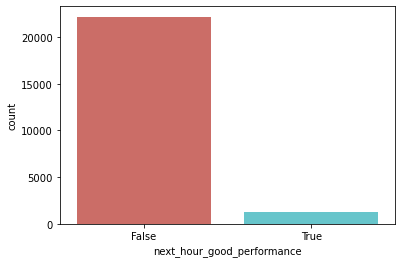

In [208]:
# Approximately ~6% ads are good of the total data with n ==1
full_data = prepared_df[prepared_df['test_set'] | prepared_df['first_24_hour']]
print('Total data size: ', full_data.shape[0])

test_set = full_data[full_data['test_set']]
print('Test data total ads: ', test_set.shape[0])
print('Number of ads with good performance: {}'.format(test_set[test_set.next_hour_good_performance>0].shape[0]))
print('{}%'.format((100*test_set[test_set.next_hour_good_performance>0].shape[0])/test_set.shape[0]))

training_data = full_data[full_data['first_24_hour']]
print('Training data %: ', (100*training_data.shape[0])/full_data.shape[0])

good_ads = training_data[(training_data.next_hour_good_performance>0) &\
                  (training_data.first_24_hour>0)].shape[0]


print('Training data ads performing good: ', good_ads)
print('{}%'.format((100*good_ads)/training_data.shape[0]))

sns.countplot(x='next_hour_good_performance', data=full_data, palette='hls')
plt.show()

### Class Balance In test set

Test data total ads:  7741
Number of ads with good performance: 362
4.676398398139775%


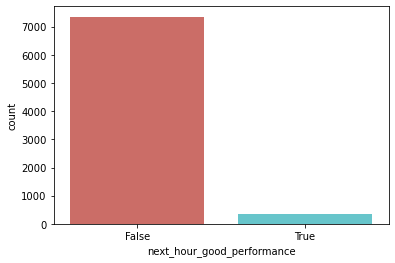

In [167]:
#Class Balance In test set: 
#41 vs 829 with actual threshold~6%

test_set = full_data[full_data['test_set']]
print('Test data total ads: ', test_set.shape[0])
print('Number of ads with good performance: {}'.format(test_set[test_set.next_hour_good_performance>0].shape[0]))
print('{}%'.format((100*test_set[test_set.next_hour_good_performance>0].shape[0])/test_set.shape[0]))
sns.countplot(x='next_hour_good_performance',data=test_set, palette='hls')
plt.show()

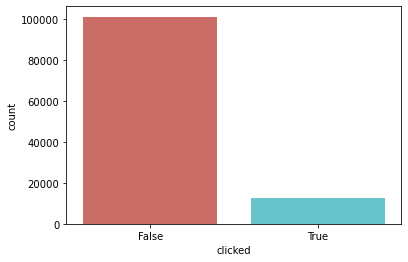

In [316]:
sns.countplot(x='clicked',data=prepared_df, palette='hls')
plt.show();

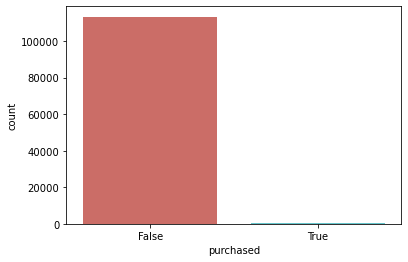

In [317]:
sns.countplot(x='purchased',data=prepared_df, palette='hls')
plt.show();

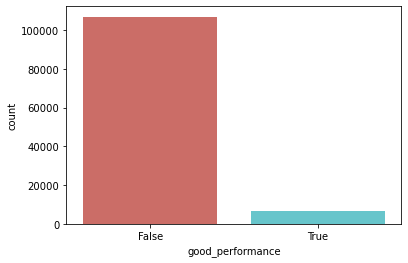

In [318]:
sns.countplot(x='good_performance',data=prepared_df, palette='hls')
plt.show();

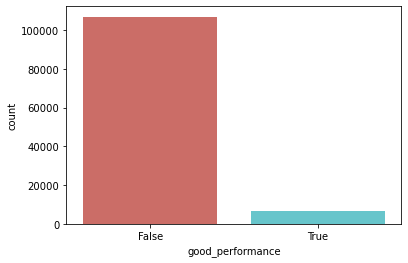

In [319]:
sns.countplot(x='good_performance',data=prepared_df, palette='hls')
plt.show();

Number of ads with good performance: 54


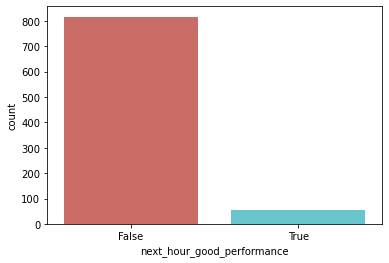

In [320]:
#Class Balance In target: 
#5 vs 865 with actual threshold
#54 vs 816 with actual threshold

get_last_hour_labels = prepared_df.sort_values(['datetime']).groupby('unique_ids').last().reset_index()
print('Number of ads with good performance: {}'.format(get_last_hour_labels[get_last_hour_labels.next_hour_good_performance>0].shape[0]))
sns.countplot(x='next_hour_good_performance',data=get_last_hour_labels, palette='hls')
plt.show();

### Hourly Pattern

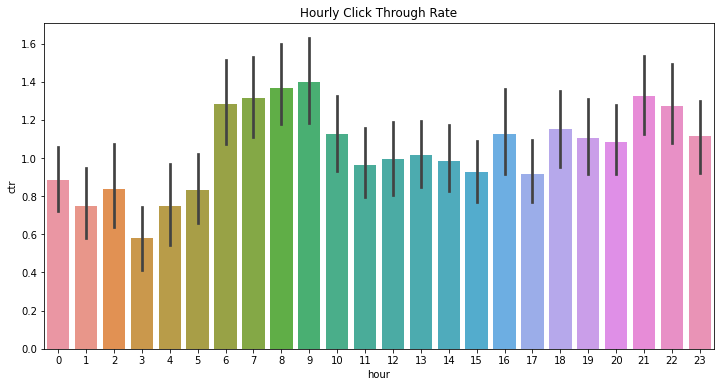

In [225]:
plt.figure(figsize=(12,6))
sns.barplot(y='ctr', x='hour', data=prepared_df.dropna())
plt.title('Hourly Click Through Rate');

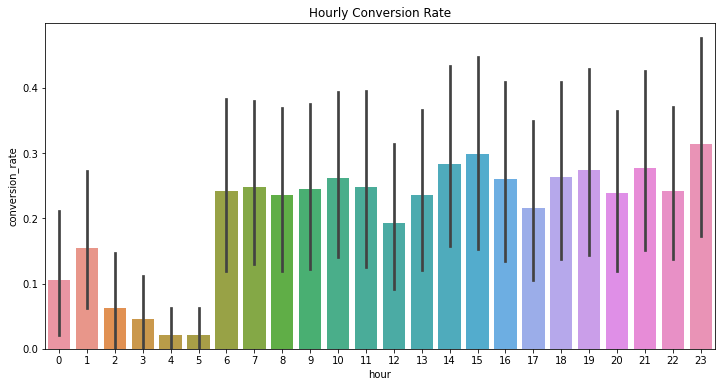

In [170]:
plt.figure(figsize=(12,6))
sns.barplot(y='conversion_rate', x='hour', data=prepared_df)
plt.title('Hourly Conversion Rate');

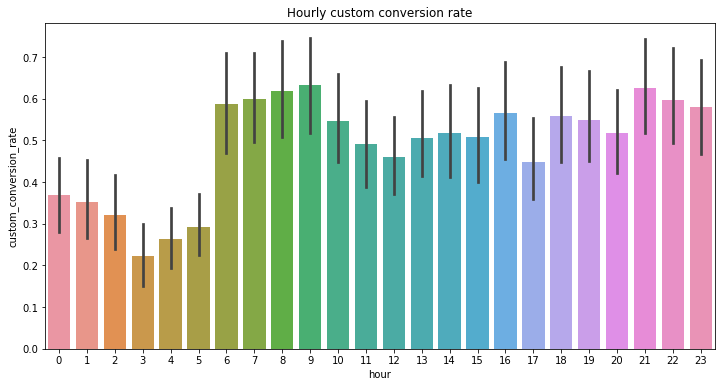

In [171]:
plt.figure(figsize=(12,6))
sns.barplot(y='custom_conversion_rate', x='hour', data=prepared_df)
plt.title('Hourly custom conversion rate');

### Day Of Week

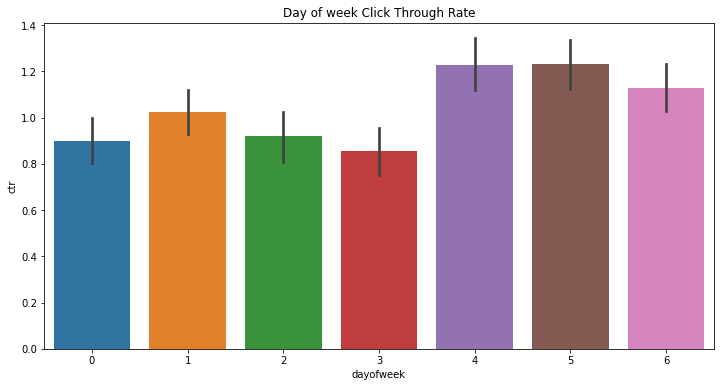

In [271]:
plt.figure(figsize=(12,6))
sns.barplot(y='ctr', x='dayofweek', data=prepared_df)
plt.title('Day of week Click Through Rate');

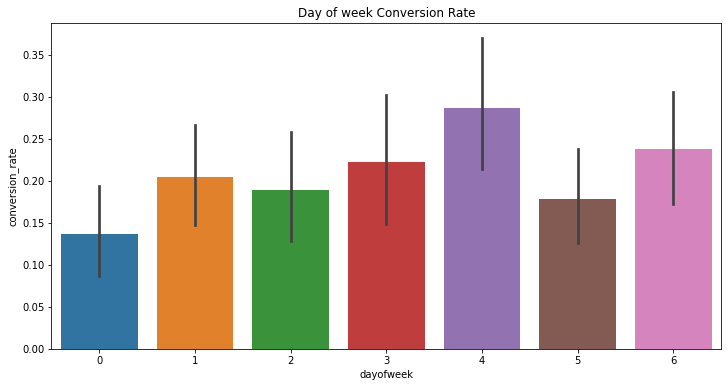

In [272]:
plt.figure(figsize=(12,6))
sns.barplot(y='conversion_rate', x='dayofweek', data=prepared_df)
plt.title('Day of week Conversion Rate');

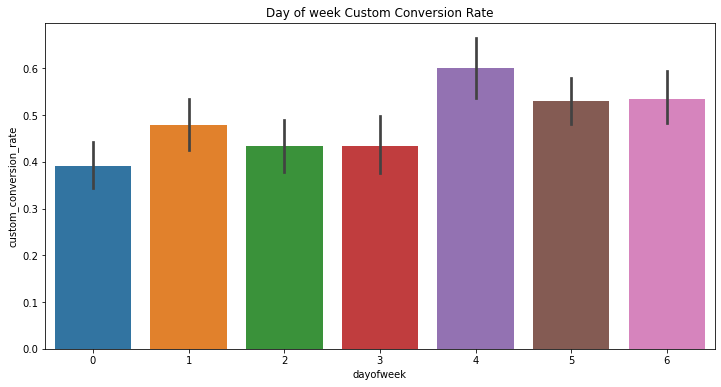

In [268]:
plt.figure(figsize=(12,6))
sns.barplot(y='custom_conversion_rate', x='dayofweek', data=prepared_df)
plt.title('Day of week Custom Conversion Rate');

In [265]:
prepared_df['dayofweek']

0      4
1      4
2      4
3      4
4      4
      ..
320    0
321    0
322    0
323    0
324    0
Name: dayofweek, Length: 113687, dtype: int64

In [172]:
prepared_df[['spend', 'impressions', 'clicks', 'purchase', 'custom_conversion_rate', 'next_hour_custom_conversion_rate']].corr(method ='pearson')

KeyError: "['next_hour_custom_conversion_rate'] not in index"

In [224]:
prepared_df[['spend', 'impressions', 'clicks', 'purchase', 'custom_conversion_rate', 'next_hour_custom_conversion_rate']].corr(method ='pearson')

,spend,impressions,clicks,purchase,custom_conversion_rate,next_hour_custom_conversion_rate
spend,1.000000,0.549840,0.673146,0.106797,0.056240,0.049728
impressions,0.549840,1.000000,0.570582,0.011014,-0.000745,-0.001290
clicks,0.673146,0.570582,1.000000,0.082898,0.096586,0.036469
purchase,0.106797,0.011014,0.082898,1.000000,0.608426,0.028493
custom_conversion_rate,0.056240,-0.000745,0.096586,0.608426,1.000000,0.040349
next_hour_custom_conversion_rate,0.049728,-0.001290,0.036469,0.028493,0.040349,1.000000


In [231]:
last_hour_prepared_df = prepared_df.sort_values('datetime').groupby('unique_ids').last()[['custom_conversion_rate']]
last_hour_prepared_df

,custom_conversion_rate
time_series,
campaign_id_23843427462090549_ad_id_23843429354180549,0.303030
campaign_id_23843427462090549_ad_id_23843429359190549,0.325203
campaign_id_23843427462090549_ad_id_23843429359200549,0.000000
campaign_id_23843429400540549_ad_id_23843429400560549,0.000000
campaign_id_23843429400540549_ad_id_23843429400570549,0.963391
...,...
campaign_id_23845345434590549_ad_id_23845345434720549,0.083647
campaign_id_23845347387450549_ad_id_23845347387470549,0.032873
campaign_id_23845373948350549_ad_id_23845373948370549,0.000000


In [316]:
prepared_df[(prepared_df['custom_conversion_rate']<1.683) & (prepared_df['custom_conversion_rate']>1.6)]

,datetime,spend,impressions,clicks,purchase,hour,time_series,next_hour_clicks,next_hour_purchases,first_24_hour,ctr,conversion_rate,custom_conversion_rate,clicked,purchased,next_hour_custom_conversion_rate
18,2019-06-22 06:00:00,0.45,41.0,2.0,0.0,6,campaign_id_23843429400540549_ad_id_2384342940...,1.0,0.0,True,4.878049,0.0,1.626016,True,False,0.606061
2,2019-07-15 20:00:00,0.03,20.0,1.0,0.0,20,campaign_id_23843490224560549_ad_id_2384349023...,1.0,0.0,True,5.000000,0.0,1.666667,True,False,8.333333
2,2019-07-21 01:00:00,0.05,20.0,1.0,0.0,1,campaign_id_23843490224560549_ad_id_2384350429...,0.0,0.0,True,5.000000,0.0,1.666667,True,False,0.000000
11,2019-07-23 00:00:00,1.32,119.0,6.0,0.0,0,campaign_id_23843507570880549_ad_id_2384350757...,1.0,0.0,True,5.042017,0.0,1.680672,True,False,0.854701
22,2019-10-12 16:00:00,0.41,80.0,4.0,0.0,16,campaign_id_23843740720640549_ad_id_2384374072...,8.0,0.0,True,5.000000,0.0,1.666667,True,False,1.088435
16,2019-10-20 09:00:00,0.19,20.0,1.0,0.0,9,campaign_id_23843769769110549_ad_id_2384376980...,0.0,0.0,True,5.000000,0.0,1.666667,True,False,0.000000
13,2019-10-20 08:00:00,0.20,20.0,1.0,0.0,8,campaign_id_23843769769110549_ad_id_2384376981...,1.0,0.0,True,5.000000,0.0,1.666667,True,False,2.083333
8,2020-04-17 21:00:00,0.11,40.0,2.0,0.0,21,campaign_id_23844530190320549_ad_id_2384453019...,1.0,0.0,True,5.000000,0.0,1.666667,True,False,0.555556
9,2020-04-17 23:00:00,0.23,40.0,2.0,0.0,23,campaign_id_23844530190320549_ad_id_2384453536...,1.0,0.0,True,5.000000,0.0,1.666667,True,False,1.075269
1,2020-04-17 15:00:00,0.08,40.0,2.0,0.0,15,campaign_id_23844530214060549_ad_id_2384453051...,1.0,0.0,True,5.000000,0.0,1.666667,True,False,0.694444


In [304]:
prepared_df[prepared_df['custom_conversion_rate']<1.683].ctr.max()

5.042016806722689

In [294]:
prepared_df[prepared_df.custom_conversion_rate>1.683]

,datetime,spend,impressions,clicks,purchase,hour,time_series,next_hour_clicks,next_hour_purchases,first_24_hour,ctr,conversion_rate,custom_conversion_rate,clicked,purchased,next_hour_custom_conversion_rate
8,2019-06-21 20:00:00,0.64,58.0,5.0,0.0,20,campaign_id_23843427462090549_ad_id_2384342935...,0.0,0.0,True,8.620690,0.000000,2.873563,True,False,0.000000
1,2019-06-21 13:00:00,0.03,4.0,1.0,0.0,13,campaign_id_23843429400540549_ad_id_2384342940...,1.0,0.0,True,25.000000,0.000000,8.333333,True,False,3.030303
2,2019-06-21 14:00:00,0.10,11.0,1.0,0.0,14,campaign_id_23843429400540549_ad_id_2384342940...,5.0,0.0,True,9.090909,0.000000,3.030303,True,False,1.028807
9,2019-06-21 21:00:00,2.05,135.0,10.0,0.0,21,campaign_id_23843429400540549_ad_id_2384342940...,11.0,0.0,True,7.407407,0.000000,2.469136,True,False,2.169625
10,2019-06-21 22:00:00,2.88,169.0,11.0,0.0,22,campaign_id_23843429400540549_ad_id_2384342940...,5.0,0.0,True,6.508876,0.000000,2.169625,True,False,0.886525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2020-07-20 13:00:00,0.39,52.0,4.0,0.0,13,campaign_id_23845069585730549_ad_id_2384506995...,7.0,0.0,True,7.692308,0.000000,2.564103,True,False,6.862745
5,2020-07-20 14:00:00,0.54,34.0,7.0,0.0,14,campaign_id_23845069585730549_ad_id_2384506995...,0.0,0.0,True,20.588235,0.000000,6.862745,True,False,0.000000
3,2020-07-20 13:00:00,0.15,4.0,2.0,0.0,13,campaign_id_23845069585730549_ad_id_2384506999...,0.0,0.0,True,50.000000,0.000000,16.666667,True,False,0.000000
1,2020-08-16 11:00:00,10.48,19601.0,9.0,1.0,11,campaign_id_23845234240270549_ad_id_2384525574...,4.0,0.0,True,0.045916,11.111111,7.422713,True,True,0.011616


In [292]:
last_hour_prepared_df[last_hour_prepared_df>1.683]

,custom_conversion_rate
time_series,
campaign_id_23843427462090549_ad_id_23843429354180549,NaN
campaign_id_23843427462090549_ad_id_23843429359190549,NaN
campaign_id_23843427462090549_ad_id_23843429359200549,NaN
campaign_id_23843429400540549_ad_id_23843429400560549,NaN
campaign_id_23843429400540549_ad_id_23843429400570549,NaN
...,...
campaign_id_23845345434590549_ad_id_23845345434720549,NaN
campaign_id_23845347387450549_ad_id_23845347387470549,NaN
campaign_id_23845373948350549_ad_id_23845373948370549,NaN


In [235]:
last_hour_prepared_df.mean(), last_hour_prepared_df>1.683

(custom_conversion_rate    1.069377
 dtype: float64,
                                                     custom_conversion_rate
 time_series                                                               
 campaign_id_23843427462090549_ad_id_23843429354...                   False
 campaign_id_23843427462090549_ad_id_23843429359...                   False
 campaign_id_23843427462090549_ad_id_23843429359...                   False
 campaign_id_23843429400540549_ad_id_23843429400...                   False
 campaign_id_23843429400540549_ad_id_23843429400...                   False
 ...                                                                    ...
 campaign_id_23845345434590549_ad_id_23845345434...                   False
 campaign_id_23845347387450549_ad_id_23845347387...                   False
 campaign_id_23845373948350549_ad_id_23845373948...                   False
 campaign_id_23845467764400549_ad_id_23845467764...                   False
 campaign_id_23846541892040549_ad_i

In [268]:
df[df.unique_ids=='campaign_id_23843490210650549_ad_id_23843490213720549'].spend.sum()

1.4900000000000002

In [223]:
missed_purchase_infos = df[(~df.unique_ids.isin(prepared_df.unique_ids.unique())) &(df.purchase>0)]
missed_purchase_infos.unique_ids.values

array(['campaign_id_23845255826960549_ad_id_23845265141010549',
       'campaign_id_23845255826960549_ad_id_23845265141010549',
       'campaign_id_23845255826960549_ad_id_23845256153090549',
       'campaign_id_23845255826960549_ad_id_23845256153090549',
       'campaign_id_23845255826960549_ad_id_23845256153090549',
       'campaign_id_23845255826960549_ad_id_23845256153090549'],
      dtype=object)

## Relationships

In [342]:
df[['spend', 'impressions', 'clicks', 'purchase']].corr(method ='pearson')

,spend,impressions,clicks,purchase
spend,1.000000,0.516785,0.732774,0.143057
impressions,0.516785,1.000000,0.593074,0.018136
clicks,0.732774,0.593074,1.000000,0.110510
purchase,0.143057,0.018136,0.110510,1.000000


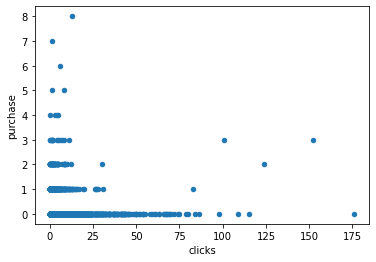

In [37]:
#purchase and clicks has sort of negative relationship
df[['clicks', 'purchase']].plot.scatter(x = 'clicks', y = 'purchase');

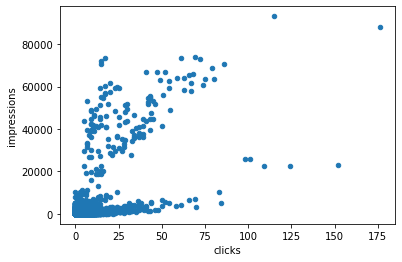

In [38]:
#views and clicks has positive relationship
df[['clicks', 'impressions']].plot.scatter(x = 'clicks', y = 'impressions');

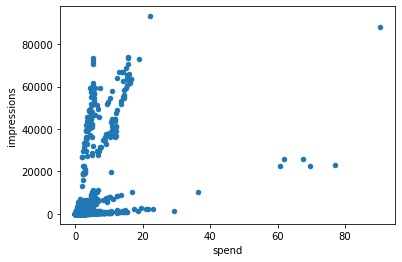

In [39]:
#spend and impressions has positive relationship
df[['spend', 'impressions']].plot.scatter(x = 'spend', y = 'impressions');

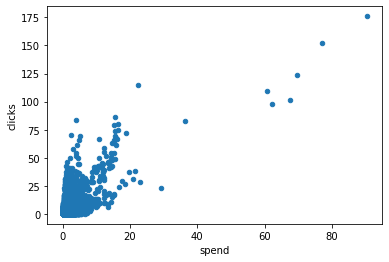

In [40]:
#spend and clicks has positive relationship
df[['spend', 'clicks']].plot.scatter(x = 'spend', y = 'clicks');

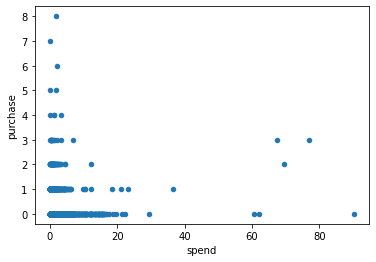

In [41]:
#spend and clicks has positive relationship
df[['spend', 'purchase']].plot.scatter(x = 'spend', y = 'purchase');

In [159]:
prepared_df[prepared_df['purchase']>0].set_index(['unique_ids', 'datetime']).index.nunique()

382

In [156]:
prepared_df[prepared_df.unique_ids=='campaign_id_23843427462090549_ad_id_23843429354180549']

,datetime,spend,impressions,clicks,purchase,hour,unique_ids,first_24_hour,ctr,conversion_rate,custom_conversion_rate,clicked,purchased,next_hour_clicks,next_hour_purchases
0,2019-06-21 12:00:00,0.00,1.0,0.0,0.0,12,campaign_id_23843427462090549_ad_id_2384342935...,True,0.000000,0.0,0.000000,False,False,0.0,0.0
1,2019-06-21 13:00:00,0.00,2.0,0.0,0.0,13,campaign_id_23843427462090549_ad_id_2384342935...,True,0.000000,0.0,0.000000,False,False,0.0,0.0
2,2019-06-21 14:00:00,0.00,0.0,0.0,0.0,14,campaign_id_23843427462090549_ad_id_2384342935...,True,0.000000,0.0,0.000000,False,False,4.0,0.0
3,2019-06-21 15:00:00,1.26,113.0,4.0,0.0,15,campaign_id_23843427462090549_ad_id_2384342935...,True,3.539823,0.0,1.179941,True,False,5.0,0.0
4,2019-06-21 16:00:00,5.50,427.0,5.0,0.0,16,campaign_id_23843427462090549_ad_id_2384342935...,True,1.170960,0.0,0.390320,True,False,6.0,0.0
5,2019-06-21 17:00:00,3.36,234.0,6.0,0.0,17,campaign_id_23843427462090549_ad_id_2384342935...,True,2.564103,0.0,0.854701,True,False,2.0,0.0
6,2019-06-21 18:00:00,2.99,198.0,2.0,0.0,18,campaign_id_23843427462090549_ad_id_2384342935...,True,1.010101,0.0,0.336700,True,False,3.0,0.0
7,2019-06-21 19:00:00,1.52,124.0,3.0,0.0,19,campaign_id_23843427462090549_ad_id_2384342935...,True,2.419355,0.0,0.806452,True,False,5.0,0.0
8,2019-06-21 20:00:00,0.64,58.0,5.0,0.0,20,campaign_id_23843427462090549_ad_id_2384342935...,True,8.620690,0.0,2.873563,True,False,0.0,0.0
9,2019-06-21 21:00:00,0.69,55.0,0.0,0.0,21,campaign_id_23843427462090549_ad_id_2384342935...,True,0.000000,0.0,0.000000,False,False,2.0,0.0


In [101]:
#prepared_df[(prepared_df['purchase']>0) & (prepared_df['ctr']==np.inf)]

In [103]:
# prepared_df[(prepared_df['purchase']>0) & (prepared_df['conversion_rate']==np.inf)].set_index(['unique_ids', 'datetime']).index.values

In [158]:
prepared_purchase_index = prepared_df[prepared_df['purchase']>0].set_index(['unique_ids', 'datetime']).index.values
len(prepared_purchase_index)

382

In [85]:
prepared_purchase_index = prepared_df[prepared_df['purchase']>0].set_index(['unique_ids', 'datetime']).index.values
len(prepared_purchase_index)

363

In [ ]:
#campaign_id_23845255826960549_ad_id_23845265141010549
#campaign_id_23845255826960549_ad_id_23845256153090549

In [142]:
df[(df.unique_ids=='campaign_id_23843490210650549_ad_id_23843504283280549') & (df.purchase>0)].sort_values('datetime')

,date,time,spend,impressions,clicks,purchase,hour,datetime,unique_ids
13277,2019-07-23,15:00:00 - 15:59:59,0.55,39,2,1.0,15,2019-07-23 15:00:00,campaign_id_23843490210650549_ad_id_2384350428...
9340,2019-07-26,06:00:00 - 06:59:59,0.16,21,1,1.0,6,2019-07-26 06:00:00,campaign_id_23843490210650549_ad_id_2384350428...
11609,2019-07-29,11:00:00 - 11:59:59,0.41,55,1,1.0,11,2019-07-29 11:00:00,campaign_id_23843490210650549_ad_id_2384350428...
9416,2019-08-01,06:00:00 - 06:59:59,0.42,19,4,1.0,6,2019-08-01 06:00:00,campaign_id_23843490210650549_ad_id_2384350428...
12587,2019-08-04,13:00:00 - 13:59:59,0.23,19,0,1.0,13,2019-08-04 13:00:00,campaign_id_23843490210650549_ad_id_2384350428...
9925,2019-08-06,07:00:00 - 07:59:59,0.95,107,5,1.0,7,2019-08-06 07:00:00,campaign_id_23843490210650549_ad_id_2384350428...
9956,2019-08-09,07:00:00 - 07:59:59,1.23,81,5,4.0,7,2019-08-09 07:00:00,campaign_id_23843490210650549_ad_id_2384350428...
16196,2019-08-09,21:00:00 - 21:59:59,2.21,207,6,1.0,21,2019-08-09 21:00:00,campaign_id_23843490210650549_ad_id_2384350428...
17089,2019-08-09,23:00:00 - 23:59:59,2.09,118,4,2.0,23,2019-08-09 23:00:00,campaign_id_23843490210650549_ad_id_2384350428...
8339,2019-08-10,02:00:00 - 02:59:59,0.35,26,2,3.0,2,2019-08-10 02:00:00,campaign_id_23843490210650549_ad_id_2384350428...


In [157]:
prepared_df[(prepared_df.unique_ids=='campaign_id_23843490210650549_ad_id_23843504283280549')].sort_values('datetime')

,datetime,spend,impressions,clicks,purchase,hour,unique_ids,first_24_hour,ctr,conversion_rate,custom_conversion_rate,clicked,purchased,next_hour_clicks,next_hour_purchases
0,2019-07-21 04:00:00,0.00,1.0,0.0,0.0,4,campaign_id_23843490210650549_ad_id_2384350428...,True,0.000000,0.0,0.000000,False,False,0.0,0.0
1,2019-07-21 05:00:00,0.00,0.0,0.0,0.0,5,campaign_id_23843490210650549_ad_id_2384350428...,True,0.000000,0.0,0.000000,False,False,0.0,0.0
2,2019-07-21 06:00:00,0.00,0.0,0.0,0.0,6,campaign_id_23843490210650549_ad_id_2384350428...,True,0.000000,0.0,0.000000,False,False,0.0,0.0
3,2019-07-21 07:00:00,0.00,0.0,0.0,0.0,7,campaign_id_23843490210650549_ad_id_2384350428...,True,0.000000,0.0,0.000000,False,False,0.0,0.0
4,2019-07-21 08:00:00,0.00,0.0,0.0,0.0,8,campaign_id_23843490210650549_ad_id_2384350428...,True,0.000000,0.0,0.000000,False,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,2019-08-10 08:00:00,3.29,221.0,6.0,0.0,8,campaign_id_23843490210650549_ad_id_2384350428...,False,2.714932,0.0,0.904977,True,False,13.0,0.0
485,2019-08-10 09:00:00,3.65,276.0,13.0,0.0,9,campaign_id_23843490210650549_ad_id_2384350428...,False,4.710145,0.0,1.570048,True,False,8.0,0.0
486,2019-08-10 10:00:00,2.06,179.0,8.0,0.0,10,campaign_id_23843490210650549_ad_id_2384350428...,False,4.469274,0.0,1.489758,True,False,0.0,0.0
487,2019-08-10 11:00:00,2.14,172.0,0.0,0.0,11,campaign_id_23843490210650549_ad_id_2384350428...,False,0.000000,0.0,0.000000,False,False,4.0,1.0


In [133]:
missed_purchase_indexes = list(set(org_purchase_index)-set(prepared_purchase_index))
len(missed_purchase_indexes), missed_purchase_indexes

(11,
 [('campaign_id_23845255826960549_ad_id_23845265141010549',
   Timestamp('2020-08-18 02:00:00')),
  ('campaign_id_23845255826960549_ad_id_23845256153090549',
   Timestamp('2020-08-16 16:00:00')),
  ('campaign_id_23843490210650549_ad_id_23843490217190549',
   Timestamp('2019-08-10 12:00:00')),
  ('campaign_id_23843490224560549_ad_id_23843490238510549',
   Timestamp('2019-08-04 20:00:00')),
  ('campaign_id_23845255826960549_ad_id_23845256153090549',
   Timestamp('2020-08-16 13:00:00')),
  ('campaign_id_23845255826960549_ad_id_23845256153090549',
   Timestamp('2020-08-16 18:00:00')),
  ('campaign_id_23845255826960549_ad_id_23845265141010549',
   Timestamp('2020-08-18 01:00:00')),
  ('campaign_id_23844530214060549_ad_id_23844530750480549',
   Timestamp('2020-04-23 14:00:00')),
  ('campaign_id_23845255826960549_ad_id_23845256153090549',
   Timestamp('2020-08-16 17:00:00')),
  ('campaign_id_23843490210650549_ad_id_23843504283470549',
   Timestamp('2019-07-27 16:00:00')),
  ('campaign_id

In [132]:
org_purchase_index = df[df['purchase']>0].set_index(['unique_ids', 'datetime']).index.values
len(org_purchase_index)

388

In [121]:
prepared_df[(prepared_df.unique_ids=='campaign_id_23843437921360549_ad_id_23843437921420549') & (prepared_df.purchase>0)]

,datetime,spend,impressions,clicks,purchase,hour,unique_ids,first_24_hour,ctr,conversion_rate
96,2019-06-27 13:00:00,18.60,1144.0,27.0,1.0,13.0,campaign_id_23843437921360549_ad_id_2384343792...,False,2.360140,3.703704
126,2019-06-28 19:00:00,9.86,648.0,6.0,1.0,19.0,campaign_id_23843437921360549_ad_id_2384343792...,False,0.925926,16.666667
170,2019-06-30 15:00:00,4.65,396.0,4.0,2.0,15.0,campaign_id_23843437921360549_ad_id_2384343792...,False,1.010101,50.000000
367,2019-07-08 20:00:00,12.16,1000.0,20.0,1.0,20.0,campaign_id_23843437921360549_ad_id_2384343792...,False,2.000000,5.000000
369,2019-07-08 22:00:00,10.39,910.0,9.0,1.0,22.0,campaign_id_23843437921360549_ad_id_2384343792...,False,0.989011,11.111111
386,2019-07-09 15:00:00,3.12,271.0,2.0,2.0,15.0,campaign_id_23843437921360549_ad_id_2384343792...,False,0.738007,100.000000
388,2019-07-09 17:00:00,4.31,308.0,1.0,1.0,17.0,campaign_id_23843437921360549_ad_id_2384343792...,False,0.324675,100.000000
409,2019-07-10 14:00:00,3.57,306.0,3.0,1.0,14.0,campaign_id_23843437921360549_ad_id_2384343792...,False,0.980392,33.333333


In [118]:
set(missed_purchase_indexes)-set(prepared_df[(prepared_df['purchase']>0) & (prepared_df['conversion_rate']==np.inf)].set_index(['unique_ids', 'datetime']).index.values)

{('campaign_id_23843437921360549_ad_id_23843437921420549',
  Timestamp('2019-07-10 14:00:00')),
 ('campaign_id_23843437921380549_ad_id_23843437921400549',
  Timestamp('2019-07-10 14:00:00')),
 ('campaign_id_23843490210650549_ad_id_23843504283280549',
  Timestamp('2019-08-10 12:00:00')),
 ('campaign_id_23843490224560549_ad_id_23843490230190549',
  Timestamp('2019-08-11 18:00:00')),
 ('campaign_id_23843507570880549_ad_id_23843507570920549',
  Timestamp('2019-07-30 14:00:00')),
 ('campaign_id_23843507570880549_ad_id_23843507575660549',
  Timestamp('2019-07-30 14:00:00')),
 ('campaign_id_23843769769110549_ad_id_23843769787560549',
  Timestamp('2019-11-12 10:00:00')),
 ('campaign_id_23844530214060549_ad_id_23844530750480549',
  Timestamp('2020-04-23 14:00:00')),
 ('campaign_id_23845069571510549_ad_id_23845069579250549',
  Timestamp('2020-07-26 10:00:00')),
 ('campaign_id_23845069571510549_ad_id_23845069699160549',
  Timestamp('2020-08-07 12:00:00')),
 ('campaign_id_23845069571510549_ad_id_2

In [69]:
df[df.purchase>0]

,date,time,spend,impressions,clicks,purchase,hour,datetime,unique_ids
304,2019-08-11,07:00:00 - 07:59:59,0.100000,15,0,1.0,7,2019-08-11 07:00:00,campaign_id_23843490224560549_ad_id_2384349022...
337,2019-06-30,08:00:00 - 08:59:59,1.500000,134,0,1.0,8,2019-06-30 08:00:00,campaign_id_23843437921380549_ad_id_2384343792...
353,2019-07-16,08:00:00 - 08:59:59,0.040000,3,1,1.0,8,2019-07-16 08:00:00,campaign_id_23843490210650549_ad_id_2384349021...
576,2019-07-21,08:00:00 - 08:59:59,0.030000,11,0,1.0,8,2019-07-21 08:00:00,campaign_id_23843490224560549_ad_id_2384349023...
709,2019-08-03,08:00:00 - 08:59:59,0.090000,9,1,1.0,8,2019-08-03 08:00:00,campaign_id_23843490224560549_ad_id_2384349023...
...,...,...,...,...,...,...,...,...,...
52672,2019-07-16,01:00:00 - 01:59:59,0.010000,2,0,1.0,1,2019-07-16 01:00:00,campaign_id_23843490224560549_ad_id_2384349023...
53512,2019-08-04,04:00:00 - 04:59:59,0.060000,6,0,2.0,4,2019-08-04 04:00:00,campaign_id_23843490224560549_ad_id_2384349022...
53905,2019-07-17,06:00:00 - 06:59:59,0.009796,3,1,1.0,6,2019-07-17 06:00:00,campaign_id_23843490210650549_ad_id_2384349021...
54168,2019-08-10,06:00:00 - 06:59:59,0.030000,5,0,1.0,6,2019-08-10 06:00:00,campaign_id_23843490210650549_ad_id_2384349021...


### Relationships with purchase

In [160]:
prepared_df[prepared_df['purchase']>0]['conversion_rate']

21      14.285714
3      100.000000
96       3.703704
126     16.666667
170     50.000000
          ...    
66     100.000000
69     100.000000
106    100.000000
93     100.000000
114    100.000000
Name: conversion_rate, Length: 382, dtype: float64

In [161]:
prepared_df['conversion_rate'].mean(), prepared_df['conversion_rate'].mode(), prepared_df['conversion_rate'].max()

(0.20740781427285784,
 0    0.0
 dtype: float64,
 100.0)

In [162]:
prepared_df['conversion_rate'].mean(), prepared_df['conversion_rate'].mode(), prepared_df['conversion_rate'].max()

(0.20740781427285784,
 0    0.0
 dtype: float64,
 100.0)

In [163]:
prepared_df['ctr'].mean(), prepared_df['ctr'].mode(), prepared_df['ctr'].max()

(1.0512748190442134,
 0    0.0
 dtype: float64,
 100.0)

In [21]:
purchased_ads = df[df.purchase>0][['ad_id','date']]
purchased_ads

,ad_id,date
304,23843490229620549,2019-08-11
337,23843437921450549,2019-06-30
353,23843490216990549,2019-07-16
576,23843490230190549,2019-07-21
709,23843490236750549,2019-08-03
...,...,...
52672,23843490232290549,2019-07-16
53512,23843490229620549,2019-08-04
53905,23843490217190549,2019-07-17
54168,23843490215490549,2019-08-10


In [145]:
df[df.ad_id==23843490229620549].sort_values(['date', 'time'])

,campaign_id,ad_id,date,time,spend,impressions,clicks,purchase,month,year,quarter,dayofweek,hour
4524,23843490224560549,23843490229620549,2019-07-15,18:00:00 - 18:59:59,0.00,2,1,0.0,0,2019,1,0,18
5012,23843490224560549,23843490229620549,2019-07-15,19:00:00 - 19:59:59,0.07,18,0,0.0,0,2019,1,0,19
5502,23843490224560549,23843490229620549,2019-07-15,20:00:00 - 20:59:59,0.06,20,0,0.0,0,2019,1,0,20
6002,23843490224560549,23843490229620549,2019-07-15,21:00:00 - 21:59:59,0.03,12,0,0.0,0,2019,1,0,21
6512,23843490224560549,23843490229620549,2019-07-15,22:00:00 - 22:59:59,0.04,9,1,0.0,0,2019,1,0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3551,23843490224560549,23843490229620549,2019-08-11,15:00:00 - 15:59:59,6.89,833,8,3.0,6,2019,2,6,15
3986,23843490224560549,23843490229620549,2019-08-11,16:00:00 - 16:59:59,7.26,1037,8,0.0,6,2019,2,6,16
4443,23843490224560549,23843490229620549,2019-08-11,17:00:00 - 17:59:59,2.96,419,1,0.0,6,2019,2,6,17
4927,23843490224560549,23843490229620549,2019-08-11,18:00:00 - 18:59:59,2.13,284,3,0.0,6,2019,2,6,18


In [27]:
# Click has the highest and positive relationship with purchase
df.corr(method ='pearson').iloc[4: , :3]

,campaign_id,ad_id,spend
clicks,0.253196,0.252568,0.732774
purchase,0.013226,0.013221,0.143057


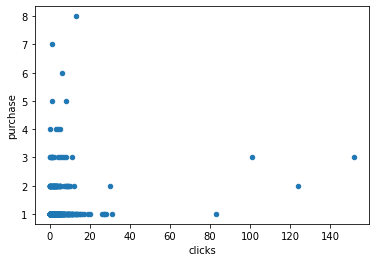

In [29]:
compare_column = 'clicks'
purchase_info[[compare_column, 'purchase']].plot.scatter(x = compare_column, y = 'purchase');

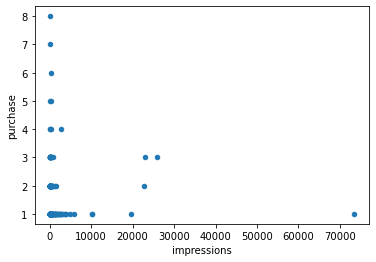

In [30]:
compare_column = 'impressions'
purchase_info[[compare_column, 'purchase']].plot.scatter(x = compare_column, y = 'purchase');

### Possible Metric
https://www.monetizemore.com/blog/what-is-the-best-metric-to-measure-ad-performance/

In [136]:
1/0

ZeroDivisionError: division by zero

In [104]:
list(set(org_purchase_index)-set(prepared_purchase_index) -set(prepared_df[(prepared_df['purchase']>0) & (prepared_df['conversion_rate']==np.inf)].set_index(['unique_ids', 'datetime']).index.values))

[('campaign_id_23845255826960549_ad_id_23845265141010549',
  Timestamp('2020-08-18 02:00:00')),
 ('campaign_id_23843507570880549_ad_id_23843507570920549',
  Timestamp('2019-07-30 14:00:00')),
 ('campaign_id_23845255826960549_ad_id_23845256153090549',
  Timestamp('2020-08-16 13:00:00')),
 ('campaign_id_23845255826960549_ad_id_23845265141010549',
  Timestamp('2020-08-18 01:00:00')),
 ('campaign_id_23845255826960549_ad_id_23845256153090549',
  Timestamp('2020-08-16 17:00:00')),
 ('campaign_id_23843490210650549_ad_id_23843504283280549',
  Timestamp('2019-08-10 12:00:00')),
 ('campaign_id_23843490224560549_ad_id_23843490230190549',
  Timestamp('2019-08-11 18:00:00')),
 ('campaign_id_23843437921360549_ad_id_23843437921420549',
  Timestamp('2019-07-10 14:00:00')),
 ('campaign_id_23843437921380549_ad_id_23843437921400549',
  Timestamp('2019-07-10 14:00:00')),
 ('campaign_id_23844530214060549_ad_id_23844530750480549',
  Timestamp('2020-04-23 14:00:00')),
 ('campaign_id_23843769769110549_ad_id_2

In [112]:
len(set(prepared_df[(prepared_df['purchase']>0) & (prepared_df['conversion_rate']==np.inf)].set_index(['unique_ids', 'datetime']).index.values))

81